In [ ]:
import os
%load_ext autoreload
%autoreload 2

from FlexivPy.joy import XBoxController
joy = XBoxController(0)
joy.getStates()

pygame 2.6.1 (SDL 2.28.4, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


Authorization required, but no authorization protocol specified

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


Put your stick at reset and do not touch it while calibrating


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


{'left_joy': array([ 0., -0.]),
 'right_joy': array([ 0., -0.]),
 'left_trigger': 0.0004999999999999449,
 'right_trigger': 0.0004999999999999449,
 'A': 0,
 'B': 0,
 'X': 0,
 'Y': 0,
 'left_bumper': 0,
 'right_bumper': 0,
 'options_left': 0,
 'options_right': 0,
 'left_joy_btn': 0,
 'right_joy_btn': 0}

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun o

Before going through the next cells, start the asynchronous simulator or the real robot bridge by tunning the following in your terminal:

**Asynchronous Simulator:**

```bash
flexivpy_async_sim --mode velocity
```

**Real Robot Client**

```bash
robot_server -cm 3 -g --path /home/FlexivPy/FlexivPy/assets/ -rcf /home/FlexivPy/flexivpy_bridge/config.yaml
```
The `cm` 3 means that the robot is started in joint velocity mode.

waiting to receive the first message from the robot...
Robot is ready!
waiting to receive the image ...
Camera is ready!
<class 'numpy.ndarray'>


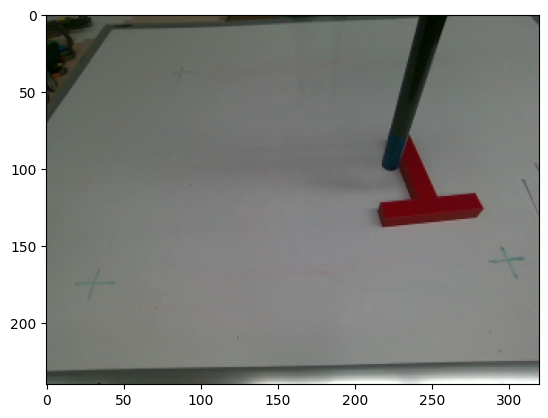

In [2]:
import pinocchio as pin
import numpy as np
from FlexivPy.robot.model.pinocchio import FlexivModel
from FlexivPy.robot.interface import FlexivDDSClient
import time
from FlexivPy.robot.dds.subscriber import get_last_msg
import cv2
from cyclonedds.domain import DomainParticipant
from cyclonedds.topic import Topic
from cyclonedds.sub import Subscriber, DataReader
import time

from cyclonedds.domain import DomainParticipant
from cyclonedds.topic import Topic
from FlexivPy.robot.dds.flexiv_messages import EnvImage
from datetime import datetime
import matplotlib.pyplot as plt


class CameraDDSClient:
    def __init__(self):

        self.domain_participant = DomainParticipant(10)

        self.topic_env_image = Topic(self.domain_participant, "EnvImage", EnvImage)
        self.subscriber_env_image = Subscriber(self.domain_participant)
        self.reader_env_image = DataReader(
            self.subscriber_env_image, self.topic_env_image
        )

        self.warning_no_env_image_dt = 0.2
        self.warning_no_env_image_send = 0.2

        self.max_wait_time_first_msg = 20

        

        # create a smiluation in another process
        self.last_img = None

        tic = time.time()
       
        self.time_last_img = tic

        tic = time.time()
        print("waiting to receive the image ...")
        while True:
            if self.is_ready():
                print("Camera is ready!")
                break
            if time.time() - tic > self.max_wait_time_first_msg:
                raise Exception("Camera is not ready! -- Start the server first!")
            time.sleep(.1)

    def is_ready(self):
        return self.get_env_image() is not None


    def get_env_image(self):
        tic = time.time()
        msg = get_last_msg(self.reader_env_image, EnvImage)
        if msg:
            now = datetime.now()  # TODO: avoid calling tic twice
            # print(now.strftime("%Y-%m-%d %H:%M:%S.%f")[:-4])
            # print("msg.time", msg.timestamp)
            np_array = np.frombuffer(bytes(msg.data), dtype=np.uint8)
            frame = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
            self.last_img = frame
            self.time_last_img = tic
            self.warning_no_env_image_send = False
        else:
            if (
                tic - self.time_last_img > self.warning_no_env_image_dt
                and not self.warning_no_env_image_send
            ):
                print(
                    f"warning: client did not recieve env image in  last {self.warning_no_env_image_dt} [s]"
                )
                self.warning_no_env_image_send = True
                self.warning_no_env_image_send = False

        return self.last_img


model = FlexivModel()
robot = FlexivDDSClient()
# Run this in another terminal!
# python FlexivPy/async_camera_app.py

camera = CameraDDSClient()
image = camera.get_env_image()
print(type(image))
plt.imshow(image)

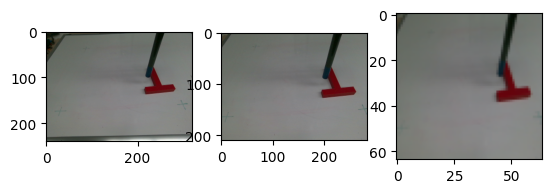

In [3]:
import matplotlib.pyplot as plt

import cv2
import numpy as np


def get_small_image(image):

    # Assuming 'image' is your NumPy array image
    # Note: OpenCV uses width before height
    # new_width = int(image.shape[1] / 4 )
    # new_height = int( image.shape[0]  /  4 )
    # new_dimensions = (new_width, new_height)
    # print("new dimensions ", new_dimensions)

    # # Resize the image with INTER_AREA interpolation (best for shrinking)
    # image_resized = cv2.resize(image, new_dimensions, interpolation=cv2.INTER_AREA)


    # # Extract the central 64x64 pixels
    # height, width = image_resized.shape[:2]
    # central_size = 64
    # half_size = central_size // 2

    # center_y = height // 2
    # center_x = width // 2

    # start_y = max(0, center_y - half_size)
    # start_y = 2
    # start_x = max(0, center_x - half_size)
    # end_y = start_y + central_size
    # end_x = start_x + central_size

    # end_y = min(height, end_y)
    # end_x = min(width, end_x)


    # print("start x", start_x)
    # print("start y", start_y)

    start_y = 10
    end_y = -20
    start_x = 20
    end_x = -15


    interest_area = image[start_y:end_y, start_x:end_x]
    # print("interest area" , interest_area.shape)
    interest_area_6464 = cv2.resize(interest_area, (64,64), interpolation=cv2.INTER_AREA)
    return interest_area_6464 , interest_area


image = camera.get_env_image()
small_image , interest_area =  get_small_image(image)


fig, ax = plt.subplots(1,3)


# convert the i
ax[0].imshow(image)
ax[1].imshow(interest_area)
ax[2].imshow(small_image)


In [4]:
# close the griper.
from FlexivPy.controllers.gripper import CloseGripper, OpenGripper
from FlexivPy.controllers.runners import NonBlockingRunner, blocking_runner
import time

controller = CloseGripper(control_mode="velocity")
# controller = OpenGripper(control_mode="velocity")


status =  blocking_runner(
    robot, 
    controller, 
    timeout=10,
    callback=None
    )



closed
goal reached


In [ ]:
from FlexivPy.controllers.taskspace import DiffIKController
import imageio
import pickle
import numpy as np
from PIL import Image
import pathlib

from datetime import datetime
import json

from zoneinfo import ZoneInfo


class Get_T_from_controller_no_drift:
    def __init__(self):
        self.T0 = None
    # Initialize the desired pose
        self.x0 = 0
        self.y0 = 0.
        self.z0 = 0.
        self.R0 = np.eye(3)
        

    def __call__(self,state):
      
        if self.T0 is None: 
            info = model.getInfo(np.array(state.q), np.array(state.dq))
            self.T0 = info["poses"]["link7"]
       
       

        rate = .2 / 100.0

        joy_state = joy.getStates()
        left_joy = joy_state["left_joy"]
        right_joy = joy_state["right_joy"]

        if joy_state["right_bumper"] == 0:
            vx_cmd = -1 * right_joy[0]
            vy_cmd = right_joy[1]
            vz_cmd = left_joy[0]
            if np.abs(vx_cmd) < 0.1:
                vx_cmd = 0
            if np.abs(vy_cmd) < 0.1:
                vy_cmd = 0
            if np.abs(vz_cmd) < 0.1:
                vz_cmd = 0
            self.y0 = self.y0 + vy_cmd * rate
            self.x0 = self.x0 + vx_cmd * rate
            self.z0 = self.z0 - vz_cmd * rate
        else:
            wx_cmd = right_joy[1]
            wy_cmd = right_joy[0]
            wz_cmd = left_joy[0]
            if np.abs(wx_cmd) < 0.1:
                wx_cmd = 0
            if np.abs(wy_cmd) < 0.1:
                wy_cmd = 0
            if np.abs(wz_cmd) < 0.1:
                wz_cmd = 0
            cmd = np.array([wx_cmd, wy_cmd, wz_cmd])
            omega_hat = np.array(
                [[0, -cmd[2], cmd[1]], [cmd[2], 0, -cmd[0]], [-cmd[1], cmd[0], 0]]
            )
            self.R0 = self.R0 @ (np.eye(3) + omega_hat / 100)

        # time.sleep(0.01)
        T_cmd = self.T0 @ np.vstack(
            [np.hstack([self.R0, np.array([self.x0, self.y0, self.z0]).reshape(3, 1)]), np.array([0, 0, 0, 1])]
        )
        return T_cmd


get_T_from_controller_no_drift = Get_T_from_controller_no_drift()

task_controller = DiffIKController(
    model, T_cmd_fun=get_T_from_controller_no_drift, dt=0.01, dq_max=1.0, control_mode="velocity"
)


class CallbackFun(): 
    def __init__(self , img_dir):
        self.cmds = []
        self.callback_dt = 0.1
        self.states = []
        self.imgs = []
        self.img_names = []
        self.last_callback_t = -1
        self.img_counter = 0
        self.img_dir = img_dir

    def __call__(self, robot, cmd , _):
        tic = time.time()
        if tic - self.last_callback_t > self.callback_dt:
            self.last_callback_t = tic
            self.cmds.append(cmd)
            self.states.append(robot.get_robot_state())

            # store the image as png. 

            img = camera.get_env_image()
            # tic = time.time()

            small_image , interest_area =  get_small_image(img)

            # this is too slow! i need to do it in another thread!
            im = Image.fromarray(small_image)
            fout = self.img_dir / f"img_{self.img_counter:09d}.png"
            self.img_names.append(str(fout))
            im.save(fout)
            # toc = time.time()
            # print("time save image" , toc - tic)
            self.img_counter += 1
            # self.imgs.append()



# Get local time zone (replace with your desired time zone if needed)
local_timezone = ZoneInfo("America/New_York")  # Replace with your timezone

# Get current date and time
current_datetime = datetime.now(local_timezone)

# Format the datetime string for folder name
folder_name = current_datetime.strftime("%Y-%m-%d__%H-%M-%S")


img_dir = pathlib.Path("data_t_v0") / folder_name / "img/"
data_dir =  pathlib.Path("data_t_v0") / folder_name / "data/"
img_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

callback = CallbackFun(img_dir = img_dir)


status = blocking_runner(robot, task_controller, timeout=10*60, callback=callback)


max time reached


In [7]:
print(len(callback.imgs))
# lets create a video. 
                        
import pickle                            
import numpy as np
from PIL import Image
import pathlib


# imageio.mimsave("tmp.mp4" , np.stack(callback.imgs) , fps=10., codec = "h264")

# save imgs as png.

# img_dir = pathlib.Path("data_t_v0") / folder_name / "img/"
data_dir =  pathlib.Path("data_t_v0") / folder_name / "data/"




# for i, img in enumerate(callback.imgs) : 
#     #
#     im = Image.fromarray(img)
#     fout = img_dir / f"img_{i:09d}.png"
#     img_names.append(str(fout))
#     im.save(fout)

Dataout = {
            "q": [ [i for i in x.q ] for x in callback.states ] ,
            "dq" :  [ [i for i in x.dq ] for x in callback.states ] ,
            "imgs" : callback.img_names
        }

with open(data_dir / "data.pkl", "wb") as f:
    pickle.dump(
        Dataout , f
    )

with open(data_dir / "data.json", "w") as f:
    json.dump(
        Dataout
        , f
    )



0


In [ ]:
with open("all_data.pkl", "rb") as f:
    D = pickle.load(f)
print(D.keys())
print(D["q"][0])
print(D["imgs"][0])

In [ ]:
import cv2
import threading
import matplotlib.pyplot as plt
import time
class QVideoCapture:
    def __init__(self, name):
        self.cap = cv2.VideoCapture(name)
        self.lock = threading.Lock()
        self.running = True  # Flag to control the thread
        self.t = threading.Thread(target=self._reader)
        self.t.start()

    # Grab frames as soon as they are available
    def _reader(self):
        while self.running:
            with self.lock:
                ret = self.cap.grab()
                time.sleep(0.01)
                # sleep 
            if not ret:
                # If grabbing fails, perhaps the camera was disconnected
                break

    # Retrieve the latest frame
    def read(self):
        with self.lock:
            ret, frame = self.cap.retrieve()
        return ret, frame

    def release(self):
        self.running = False
        self.t.join()
        self.cap.release()


cap = QVideoCapture(5)
ret,frame = cap.read()

fig, ax = plt.subplots(1,3)
cap.release()

# convert the i
ax[0].imshow(frame)



In [ ]:
import atexit
import subprocess

# Example: Starting a process


def cleanup():
    with open("tmp.log", "r") as f:
        f.write("hello\n")


# Register the cleanup function
atexit.register(cleanup)

In [ ]:
from FlexivPy.vision import RealSenseCamera
import signal

running = True



# get an image. 

# Camera to the right of the robot
# camera2 = RealSenseCamera(VGA=False, camera_serial_no='231622302407')

# Camera to the left of the robot
camera1 = RealSenseCamera(VGA=False, camera_serial_no='234222302193')





# get an image. 


In [ ]:
camera1.close()

In [ ]:
qs = []
callback_dt = .1
last_callback_t = -1

cmds = []
states = []
imgs = []





runner = NonBlockingRunner(robot, task_controller, timeout=120. , callback=callback)

In [ ]:
import time
import numpy as np
import datetime





In [ ]:
# lets store the data.
import pickle

fout = "tmp_data_v0.pkl"

with open(fout, "wb") as f:
    pickle.dump({"cmds": cmds, "states": states, "imgs": imgs}, f)